In [4]:
import math
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, UnidentifiedImageError
from pathlib import Path
import torch
import glob
import pytorch_lightning as pl
from huggingface_hub import HfApi, Repository
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchmetrics import Accuracy
from transformers import ViTFeatureExtractor, ViTForImageClassification
from pytorch_lightning.callbacks import ModelCheckpoint
import json
import pandas as pd
import os
import matplotlib
import shutil
import scikitplot as skplt
import albumentations as A
import cv2
from albumentations.pytorch.transforms import ToTensorV2
from torchvision import transforms
from pytorch_lightning.loggers import TensorBoardLogger
import tqdm

In [5]:
import torchmetrics
print(torch.__version__)
print(torch.version.cuda)
print(torchmetrics.__version__)

1.13.1
11.6
0.10.3


In [15]:
MODEL_NUMBER = 1.1

In [7]:
#albumentations
class Transforms:
    def __init__(self, transforms: A.Compose):
        self.transforms = transforms

    def __call__(self, img, *args, **kwargs):
        return self.transforms(image=np.array(img))['image']
    
transform = A.Compose(
    [
        ToTensorV2(),
    ]
)

In [8]:
data_dir = Path(f"./dataset/train")
ds=ImageFolder(data_dir,transform=Transforms(transforms=transform))
indices = torch.randperm(len(ds)).tolist()
n_val = math.floor(len(indices) * .20)
train_ds = torch.utils.data.Subset(ds, indices[:-n_val])
val_ds = torch.utils.data.Subset(ds, indices[-n_val:])

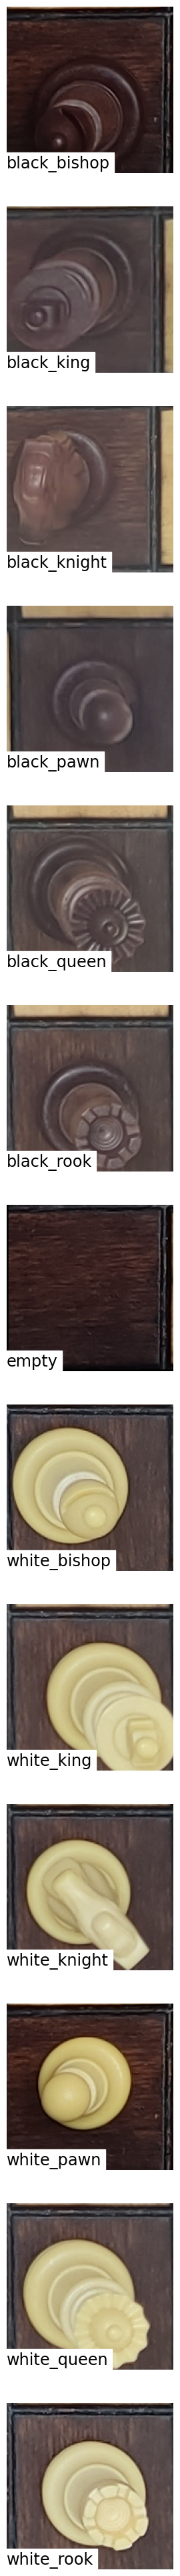

In [9]:
plt.figure(figsize=(100,50))
num_examples_per_class = 1
i = 1
for class_idx, class_name in enumerate(ds.classes):
  folder = ds.root / class_name
  for image_idx, image_path in enumerate(sorted(folder.glob('*'))):
    if image_path.suffix in ds.extensions:
      image = Image.open(image_path)
      plt.subplot(len(ds.classes), num_examples_per_class, i)
      ax = plt.gca()
      ax.set_title(
         class_name,
         size='xx-large',
         pad=5,
         loc='left',
         y=0,
         backgroundcolor='white'
      )
      ax.axis('off')
      plt.imshow(image)
      i += 1
      if image_idx + 1 == num_examples_per_class:
         break

In [10]:
class ImageClassificationCollator:
   def __init__(self, feature_extractor): 
      self.feature_extractor = feature_extractor
   def __call__(self, batch):  
      encodings = self.feature_extractor([x[0] for x in batch],
      return_tensors='pt')   
      encodings['labels'] = torch.tensor([x[1] for x in batch],    
      dtype=torch.long)
      return encodings
   
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
collator = ImageClassificationCollator(feature_extractor)

/home/oit/anaconda3/envs/vit/lib/python3.8/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [11]:

train_loader = DataLoader(train_ds, batch_size=8, collate_fn=collator, num_workers=8, shuffle=True)#shuffle=True, sampler=sampler
val_loader = DataLoader(val_ds, batch_size=8, collate_fn=collator, num_workers=8)
model = ViTForImageClassification.from_pretrained(
        'google/vit-base-patch16-224-in21k',
         num_labels=len(ds.classes))

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
class Classifier(pl.LightningModule):
   #original: lr:2e-5, optimier:Adam, weight_decay:0.00025
   def __init__(self, model, lr: float = 2e-5, **kwargs): 
       super().__init__()
       self.save_hyperparameters('lr', *list(kwargs))
       self.model = model
       self.forward = self.model.forward
       self.tain_acc = Accuracy()
       self.val_acc = Accuracy()
   def training_step(self, batch, batch_idx):
       outputs = self(**batch)
       self.log(f"train_loss", outputs.loss, prog_bar=True)
       acc = self.tain_acc(outputs.logits.argmax(1), batch['labels'])
       self.log(f"train_acc", acc, prog_bar=True)
       return outputs.loss
   def validation_step(self, batch, batch_idx):
       outputs = self(**batch)
       self.log(f"val_loss", outputs.loss, prog_bar=True)
       acc = self.val_acc(outputs.logits.argmax(1), batch['labels'])
       self.log(f"val_acc", acc, prog_bar=True)
       return outputs.loss
   def configure_optimizers(self):
       return torch.optim.Adam(self.parameters(), lr=self.hparams.lr,weight_decay = 0.00025)

In [17]:
pl.seed_everything(42)
classifier = Classifier(model, lr=2e-5)
trainer = pl.Trainer(gpus=1, precision=16, max_epochs=5)
trainer.fit(classifier, train_loader, val_loader)
model.save_pretrained(f"./models/model{MODEL_NUMBER}")

Global seed set to 42
/home/oit/anaconda3/envs/vit/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                      | Params
-------------------------------------------------------
0 | model    | ViTForImageClassification | 85.8 M
1 | tain_acc | Accuracy                  | 0     
2 | val_acc  | Accuracy                  | 0     
-------------------------------------------------------
85.8 M    Trainable params
0         Non-trainable params
85.8 M    Total params
171.617   Total estimate

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


#### Inferencing on a Test Dataset

In [18]:
test_ds = ImageFolder('dataset/valid', transform=Transforms(transforms=transform))
len(test_ds)

832

In [19]:
test_ds.classes

['black_bishop',
 'black_king',
 'black_knight',
 'black_pawn',
 'black_queen',
 'black_rook',
 'empty',
 'white_bishop',
 'white_king',
 'white_knight',
 'white_pawn',
 'white_queen',
 'white_rook']

In [20]:
# feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
test_loader = DataLoader(test_ds, batch_size=1 ,num_workers=1)

In [21]:
model = ViTForImageClassification.from_pretrained(
        "models/model1.1",
        num_labels=len(test_ds.classes)
)

In [22]:
gt_labels = []
preds = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  

with torch.no_grad():  # Disable gradient computation during inference
    for images, labels in test_loader:
        gt_labels.append(labels.to(device))
        images = images.to(device)
        images = images.float()
        encoding = feature_extractor(images=images, return_tensors="pt")
        # images = feature_extractor(images=images, return_tensors='pt')
        # images = images.to(device)   
        encoding = encoding.to(device)
        pixel_values = encoding['pixel_values']     
        pred = model(pixel_values)
        pred1 = pred.logits.softmax(1).argmax(1)
        preds.append(pred1)

        # save the image

In [23]:
correct_predictions = (torch.stack(preds) == torch.stack(gt_labels)).sum().item()

In [24]:
total_samples = len(gt_labels)
accuracy = (correct_predictions / total_samples ) * 100
accuracy

95.55288461538461